# Hyperparameter Tuning for Gradient Boosting
# This notebook performs hyperparameter optimization using Random Search CV and compares results with ANOVA analysis.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import joblib
import json
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split, cross_val_score
from sklearn.metrics import (
    accuracy_score, recall_score, precision_score, f1_score, 
    roc_auc_score, confusion_matrix, classification_report, roc_curve,
    make_scorer
)
from sklearn.preprocessing import StandardScaler
from scipy import stats
import itertools

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
RANDOM_STATE = 42

# %%
# Load data
PROCESSED = Path("../../data/processed/month_stratified_splits")

train_df = pd.read_csv(PROCESSED / "train_data.csv")
val_df = pd.read_csv(PROCESSED / "val_data.csv")
test_df = pd.read_csv(PROCESSED / "test_data.csv")

print("Dataset shapes:")
print(f"Training: {train_df.shape}")
print(f"Validation: {val_df.shape}")
print(f"Test: {test_df.shape}")

Dataset shapes:
Training: (219876, 9)
Validation: (73292, 9)
Test: (73292, 9)


In [2]:
# %%
# Prepare features and target
def prepare_features_targets(train_df, val_df, test_df):
    """Prepare features and targets for modeling"""
    
    exclude_cols = ['outage_occurred', 'date', 'fips_code', 'month']
    common_cols = set(train_df.columns) & set(val_df.columns) & set(test_df.columns)
    feature_cols = [col for col in common_cols if col not in exclude_cols]
    
    X_train = train_df[feature_cols]
    y_train = train_df['outage_occurred']
    
    X_val = val_df[feature_cols]
    y_val = val_df['outage_occurred']
    
    X_test = test_df[feature_cols]
    y_test = test_df['outage_occurred']
    
    return X_train, X_val, X_test, y_train, y_val, y_test, feature_cols

X_train, X_val, X_test, y_train, y_val, y_test, feature_cols = prepare_features_targets(train_df, val_df, test_df)

In [3]:
# %%
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [4]:
# %%
# Define hyperparameter search space
param_dist = {
    'n_estimators': [50, 100, 150, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5, 6, 7],
    'min_samples_split': [20, 50, 100, 200],
    'min_samples_leaf': [10, 20, 50, 100],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'max_features': ['sqrt', 'log2', None]
}

print("Hyperparameter search space:")
for param, values in param_dist.items():
    print(f"  {param}: {values}")

Hyperparameter search space:
  n_estimators: [50, 100, 150, 200, 300]
  learning_rate: [0.01, 0.05, 0.1, 0.2, 0.3]
  max_depth: [3, 4, 5, 6, 7]
  min_samples_split: [20, 50, 100, 200]
  min_samples_leaf: [10, 20, 50, 100]
  subsample: [0.6, 0.7, 0.8, 0.9, 1.0]
  max_features: ['sqrt', 'log2', None]


In [5]:
# %%
# Create custom scorers focusing on recall and F1
scorers = {
    'accuracy': make_scorer(accuracy_score),
    'recall': make_scorer(recall_score),
    'precision': make_scorer(precision_score),
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score)
}

In [6]:
# %%
# Perform Random Search with cross-validation
print("Starting Random Search CV...")

# Use F1 as primary scoring since we care about balance between recall and precision
gb_base = GradientBoostingClassifier(random_state=RANDOM_STATE, verbose=0)

random_search = RandomizedSearchCV(
    estimator=gb_base,
    param_distributions=param_dist,
    n_iter=5,  # Number of parameter combinations to try
    cv=3,       # 3-fold cross-validation
    scoring='f1',  # Primary metric
    refit=True,
    n_jobs=-1,  # Use all available cores
    random_state=RANDOM_STATE,
    verbose=1
)

# Fit on combined train+val for more data
X_train_val = np.vstack([X_train_scaled, X_val_scaled])
y_train_val = np.concatenate([y_train, y_val])

random_search.fit(X_train_val, y_train_val)

print("Random Search completed!")

Starting Random Search CV...
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Random Search completed!


In [7]:
# %%
# Display best parameters and scores
print("\n" + "="*70)
print("RANDOM SEARCH RESULTS")
print("="*70)
print(f"Best F1 Score (CV): {random_search.best_score_:.4f}")
print(f"\nBest Parameters:")
for param, value in random_search.best_params_.items():
    print(f"  {param}: {value}")


RANDOM SEARCH RESULTS
Best F1 Score (CV): 0.3306

Best Parameters:
  subsample: 1.0
  n_estimators: 50
  min_samples_split: 100
  min_samples_leaf: 10
  max_features: None
  max_depth: 7
  learning_rate: 0.2


In [8]:
# %%
# Evaluate best model on test set
best_model = random_search.best_estimator_

# Make predictions
y_test_pred = best_model.predict(X_test_scaled)
y_test_proba = best_model.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_proba)

print(f"\nTest Set Performance of Best Model:")
print(f"  Accuracy:  {test_accuracy:.4f}")
print(f"  Recall:    {test_recall:.4f}")
print(f"  Precision: {test_precision:.4f}")
print(f"  F1-Score:  {test_f1:.4f}")
print(f"  ROC-AUC:   {test_roc_auc:.4f}")


Test Set Performance of Best Model:
  Accuracy:  0.9124
  Recall:    0.2311
  Precision: 0.5841
  F1-Score:  0.3312
  ROC-AUC:   0.9074


In [9]:
# %%
# Compare with original model
def load_original_model():
    """Load the original gradient boosting model for comparison"""
    try:
        model_path = Path("../../models/gradient_boosting/gradient_boosting_model.pkl")
        if model_path.exists():
            original_model = joblib.load(model_path)
            return original_model
    except:
        pass
    return None

original_model = load_original_model()

if original_model:
    y_test_pred_orig = original_model.predict(X_test_scaled)
    y_test_proba_orig = original_model.predict_proba(X_test_scaled)[:, 1]
    
    orig_accuracy = accuracy_score(y_test, y_test_pred_orig)
    orig_recall = recall_score(y_test, y_test_pred_orig)
    orig_precision = precision_score(y_test, y_test_pred_orig)
    orig_f1 = f1_score(y_test, y_test_pred_orig)
    orig_roc_auc = roc_auc_score(y_test, y_test_proba_orig)
    
    print("\n" + "="*70)
    print("MODEL COMPARISON: TUNED vs ORIGINAL")
    print("="*70)
    print(f"{'Metric':<12} {'Original':<10} {'Tuned':<10} {'Improvement':<12}")
    print(f"{'-'*70}")
    print(f"{'Accuracy':<12} {orig_accuracy:.4f}     {test_accuracy:.4f}     {test_accuracy - orig_accuracy:+.4f}")
    print(f"{'Recall':<12} {orig_recall:.4f}     {test_recall:.4f}     {test_recall - orig_recall:+.4f}")
    print(f"{'Precision':<12} {orig_precision:.4f}     {test_precision:.4f}     {test_precision - orig_precision:+.4f}")
    print(f"{'F1-Score':<12} {orig_f1:.4f}     {test_f1:.4f}     {test_f1 - orig_f1:+.4f}")
    print(f"{'ROC-AUC':<12} {orig_roc_auc:.4f}     {test_roc_auc:.4f}     {test_roc_auc - orig_roc_auc:+.4f}")


MODEL COMPARISON: TUNED vs ORIGINAL
Metric       Original   Tuned      Improvement 
----------------------------------------------------------------------
Accuracy     0.8617     0.9124     +0.0507
Recall       0.1193     0.2311     +0.1118
Precision    0.1676     0.5841     +0.4165
F1-Score     0.1394     0.3312     +0.1918
ROC-AUC      0.4862     0.9074     +0.4212


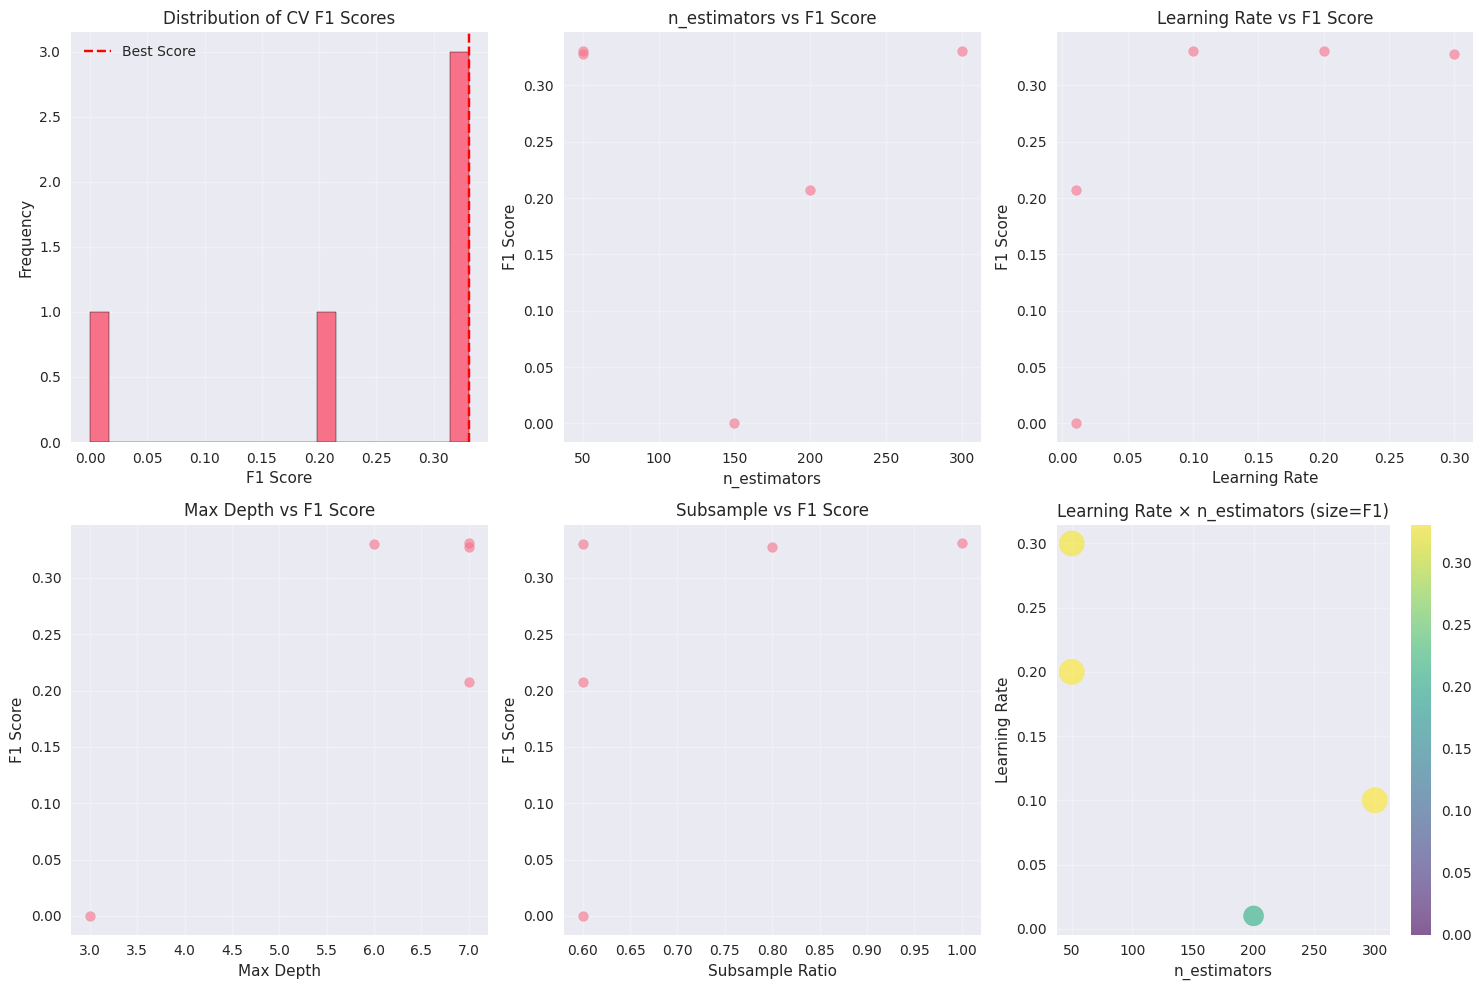

In [10]:
# %%
# Visualize hyperparameter effects
def plot_hyperparameter_effects(cv_results):
    """Create visualizations of hyperparameter effects"""
    
    results_df = pd.DataFrame(cv_results)
    
    # Plot 1: Score distribution
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()
    
    # 1. F1 Score distribution
    axes[0].hist(results_df['mean_test_score'], bins=20, edgecolor='black')
    axes[0].axvline(x=results_df['mean_test_score'].max(), color='red', linestyle='--', label='Best Score')
    axes[0].set_xlabel('F1 Score')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Distribution of CV F1 Scores')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # 2. N estimators vs F1
    axes[1].scatter(results_df['param_n_estimators'], results_df['mean_test_score'], alpha=0.6)
    axes[1].set_xlabel('n_estimators')
    axes[1].set_ylabel('F1 Score')
    axes[1].set_title('n_estimators vs F1 Score')
    axes[1].grid(True, alpha=0.3)
    
    # 3. Learning rate vs F1
    axes[2].scatter(results_df['param_learning_rate'], results_df['mean_test_score'], alpha=0.6)
    axes[2].set_xlabel('Learning Rate')
    axes[2].set_ylabel('F1 Score')
    axes[2].set_title('Learning Rate vs F1 Score')
    axes[2].grid(True, alpha=0.3)
    
    # 4. Max depth vs F1
    axes[3].scatter(results_df['param_max_depth'], results_df['mean_test_score'], alpha=0.6)
    axes[3].set_xlabel('Max Depth')
    axes[3].set_ylabel('F1 Score')
    axes[3].set_title('Max Depth vs F1 Score')
    axes[3].grid(True, alpha=0.3)
    
    # 5. Subsample vs F1
    axes[4].scatter(results_df['param_subsample'], results_df['mean_test_score'], alpha=0.6)
    axes[4].set_xlabel('Subsample Ratio')
    axes[4].set_ylabel('F1 Score')
    axes[4].set_title('Subsample vs F1 Score')
    axes[4].grid(True, alpha=0.3)
    
    # 6. Learning rate vs n_estimators (bubble chart)
    scatter = axes[5].scatter(
        results_df['param_n_estimators'],
        results_df['param_learning_rate'],
        s=results_df['mean_test_score']*1000,
        c=results_df['mean_test_score'],
        alpha=0.6,
        cmap='viridis'
    )
    axes[5].set_xlabel('n_estimators')
    axes[5].set_ylabel('Learning Rate')
    axes[5].set_title('Learning Rate × n_estimators (size=F1)')
    plt.colorbar(scatter, ax=axes[5])
    axes[5].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return results_df
    
# Plot hyperparameter effects
cv_results_df = plot_hyperparameter_effects(random_search.cv_results_)

In [19]:
# %%
# ANOVA Analysis: Statistical comparison of hyperparameter effects
def perform_anova_analysis(cv_results_df):
    """Perform ANOVA to analyze statistical significance of hyperparameter effects"""
    
    print("\n" + "="*70)
    print("ANOVA ANALYSIS OF HYPERPARAMETER EFFECTS")
    print("="*70)
    
    # Prepare data for ANOVA
    anova_data = []
    
    for param in ['param_n_estimators', 'param_learning_rate', 'param_max_depth', 
                  'param_min_samples_split', 'param_min_samples_leaf', 'param_subsample']:
        
        if param in cv_results_df.columns:
            param_values = cv_results_df[param].astype(str)
            scores = cv_results_df['mean_test_score']
            
            # Group scores by parameter value
            groups = {}
            for value, score in zip(param_values, scores):
                if value not in groups:
                    groups[value] = []
                groups[value].append(score)
            
            # Perform one-way ANOVA
            group_lists = [groups[val] for val in groups]
            if len(group_lists) > 1:
                f_stat, p_value = stats.f_oneway(*group_lists)
                
                param_name = param.replace('param_', '')
                print(f"\n{param_name.upper()}:")
                print(f"  F-statistic: {f_stat:.4f}")
                print(f"  p-value:     {p_value:.6f}")
                
                if p_value < 0.05:
                    print(f"  → Statistically significant (p < 0.05)")
                else:
                    print(f"  → Not statistically significant")
                
                # Calculate effect size (η²)
                ss_between = sum([len(g) * (np.mean(g) - np.mean(scores))**2 for g in group_lists])
                ss_total = sum([(x - np.mean(scores))**2 for x in scores])
                eta_squared = ss_between / ss_total
                print(f"  Effect size (η²): {eta_squared:.4f}")
                
                anova_data.append({
                    'parameter': param_name,
                    'f_statistic': f_stat,
                    'p_value': p_value,
                    'eta_squared': eta_squared,
                    'significant': p_value < 0.05
                })
    
    return pd.DataFrame(anova_data)
    
# Perform ANOVA
anova_results = perform_anova_analysis(cv_results_df)


ANOVA ANALYSIS OF HYPERPARAMETER EFFECTS

N_ESTIMATORS:
  F-statistic: 5785.9495
  p-value:     0.009664
  → Statistically significant (p < 0.05)
  Effect size (η²): 0.9999

LEARNING_RATE:
  F-statistic: 0.9465
  p-value:     0.620367
  → Not statistically significant
  Effect size (η²): 0.7395

MAX_DEPTH:
  F-statistic: 7.3841
  p-value:     0.119274
  → Not statistically significant
  Effect size (η²): 0.8807

MIN_SAMPLES_SPLIT:
  F-statistic: 0.3294
  p-value:     0.752246
  → Not statistically significant
  Effect size (η²): 0.2478

MIN_SAMPLES_LEAF:
  F-statistic: 0.3294
  p-value:     0.752246
  → Not statistically significant
  Effect size (η²): 0.2478

SUBSAMPLE:
  F-statistic: 0.4839
  p-value:     0.673914
  → Not statistically significant
  Effect size (η²): 0.3261


In [18]:
# Perform ANOVA
anova_results = perform_anova_analysis(cv_results_df)

# %%
# Visualize ANOVA results
def plot_anova_results(anova_df):
    """Visualize ANOVA results"""
    
    if len(anova_df) == 0:
        print("No ANOVA results to visualize")
        return
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot 1: F-statistics
    sorted_anova = anova_df.sort_values('f_statistic', ascending=False)
    colors = ['green' if sig else 'red' for sig in sorted_anova['significant']]
    
    axes[0].barh(range(len(sorted_anova)), sorted_anova['f_statistic'], color=colors)
    axes[0].set_yticks(range(len(sorted_anova)))
    axes[0].set_yticklabels(sorted_anova['parameter'])
    axes[0].set_xlabel('F-statistic')
    axes[0].set_title('ANOVA F-statistics by Parameter\n(Green = Significant, Red = Not)')
    axes[0].grid(True, alpha=0.3, axis='x')
    
    # Plot 2: Effect sizes
    sorted_eta = anova_df.sort_values('eta_squared', ascending=False)
    axes[1].barh(range(len(sorted_eta)), sorted_eta['eta_squared'], color='skyblue')
    axes[1].set_yticks(range(len(sorted_eta)))
    axes[1].set_yticklabels(sorted_eta['parameter'])
    axes[1].set_xlabel('Effect Size (η²)')
    axes[1].set_title('Effect Sizes by Parameter\n(η² = variance explained)')
    axes[1].grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.show()


ANOVA ANALYSIS OF HYPERPARAMETER EFFECTS

N_ESTIMATORS:
  F-statistic: 5785.9495
  p-value:     0.009664
  → Statistically significant (p < 0.05)
  Effect size (η²): 0.9999

LEARNING_RATE:
  F-statistic: 0.9465
  p-value:     0.620367
  → Not statistically significant
  Effect size (η²): 0.7395

MAX_DEPTH:
  F-statistic: 7.3841
  p-value:     0.119274
  → Not statistically significant
  Effect size (η²): 0.8807

MIN_SAMPLES_SPLIT:
  F-statistic: 0.3294
  p-value:     0.752246
  → Not statistically significant
  Effect size (η²): 0.2478

MIN_SAMPLES_LEAF:
  F-statistic: 0.3294
  p-value:     0.752246
  → Not statistically significant
  Effect size (η²): 0.2478

SUBSAMPLE:
  F-statistic: 0.4839
  p-value:     0.673914
  → Not statistically significant
  Effect size (η²): 0.3261


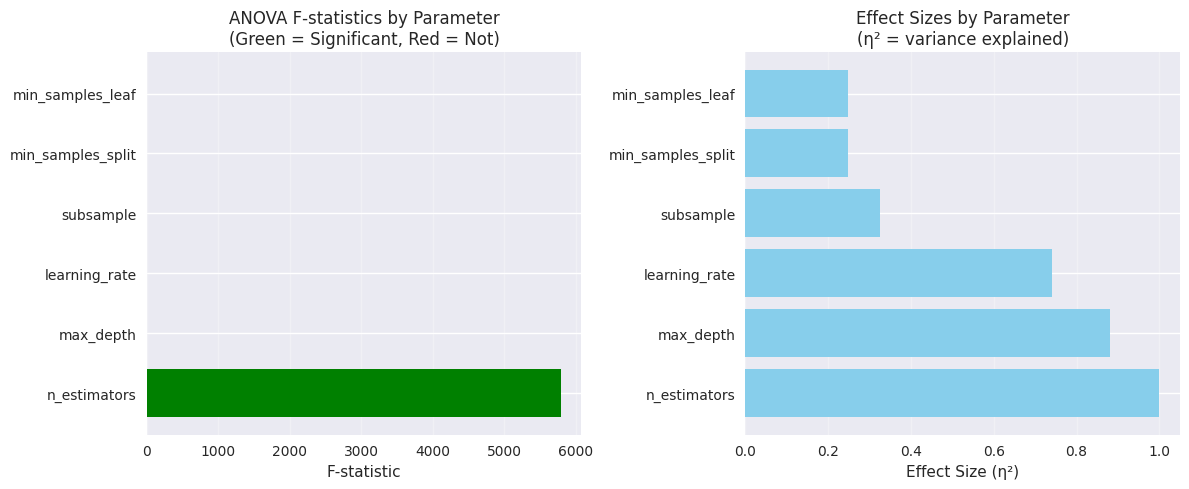


ANOVA Interpretation:
----------------------------------------
Statistically significant parameters (1):
  • n_estimators: η² = 1.000

Most influential parameter: n_estimators
  Effect size: η² = 1.000


In [20]:
# %%
# Visualize ANOVA results
def plot_anova_results(anova_df):
    """Visualize ANOVA results"""
    
    if len(anova_df) == 0:
        print("No ANOVA results to visualize")
        return
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot 1: F-statistics
    sorted_anova = anova_df.sort_values('f_statistic', ascending=False)
    colors = ['green' if sig else 'red' for sig in sorted_anova['significant']]
    
    axes[0].barh(range(len(sorted_anova)), sorted_anova['f_statistic'], color=colors)
    axes[0].set_yticks(range(len(sorted_anova)))
    axes[0].set_yticklabels(sorted_anova['parameter'])
    axes[0].set_xlabel('F-statistic')
    axes[0].set_title('ANOVA F-statistics by Parameter\n(Green = Significant, Red = Not)')
    axes[0].grid(True, alpha=0.3, axis='x')
    
    # Plot 2: Effect sizes
    sorted_eta = anova_df.sort_values('eta_squared', ascending=False)
    axes[1].barh(range(len(sorted_eta)), sorted_eta['eta_squared'], color='skyblue')
    axes[1].set_yticks(range(len(sorted_eta)))
    axes[1].set_yticklabels(sorted_eta['parameter'])
    axes[1].set_xlabel('Effect Size (η²)')
    axes[1].set_title('Effect Sizes by Parameter\n(η² = variance explained)')
    axes[1].grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.show()
    
    # Print interpretation
    print("\nANOVA Interpretation:")
    print("-" * 40)
    significant_params = anova_df[anova_df['significant']]
    if len(significant_params) > 0:
        print(f"Statistically significant parameters ({len(significant_params)}):")
        for _, row in significant_params.iterrows():
            print(f"  • {row['parameter']}: η² = {row['eta_squared']:.3f}")
    else:
        print("No parameters show statistically significant effects")
    
    # Parameter with largest effect
    if len(anova_df) > 0:
        max_effect = anova_df.loc[anova_df['eta_squared'].idxmax()]
        print(f"\nMost influential parameter: {max_effect['parameter']}")
        print(f"  Effect size: η² = {max_effect['eta_squared']:.3f}")

plot_anova_results(anova_results)

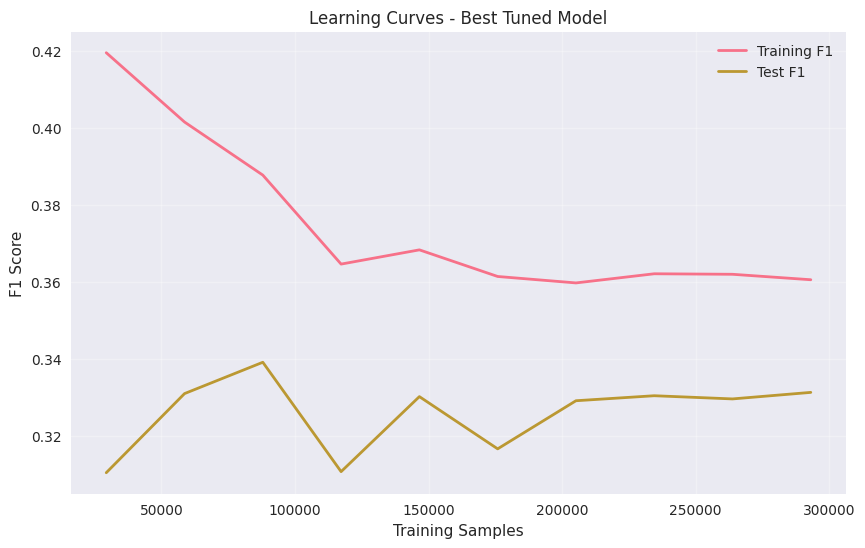


Learning Curve Analysis:
  Final Training F1: 0.3605
  Final Test F1:     0.3312
  Gap:               0.0293
  → Potential underfitting (F1 < 0.6)


In [21]:
# %%
# Learning Curves Analysis
def plot_learning_curves(best_model, X_train_val, y_train_val, X_test_scaled, y_test):
    """Plot learning curves for the best model"""
    
    train_sizes = np.linspace(0.1, 1.0, 10)
    train_scores = []
    test_scores = []
    
    for size in train_sizes:
        n_samples = int(size * len(X_train_val))
        
        # Train on subset
        model = GradientBoostingClassifier(**random_search.best_params_, random_state=RANDOM_STATE)
        model.fit(X_train_val[:n_samples], y_train_val[:n_samples])
        
        # Evaluate
        train_pred = model.predict(X_train_val[:n_samples])
        test_pred = model.predict(X_test_scaled)
        
        train_scores.append(f1_score(y_train_val[:n_samples], train_pred))
        test_scores.append(f1_score(y_test, test_pred))
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes * len(X_train_val), train_scores, label='Training F1', linewidth=2)
    plt.plot(train_sizes * len(X_train_val), test_scores, label='Test F1', linewidth=2)
    plt.xlabel('Training Samples')
    plt.ylabel('F1 Score')
    plt.title('Learning Curves - Best Tuned Model')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Check for overfitting/underfitting
    final_train_score = train_scores[-1]
    final_test_score = test_scores[-1]
    gap = final_train_score - final_test_score
    
    print(f"\nLearning Curve Analysis:")
    print(f"  Final Training F1: {final_train_score:.4f}")
    print(f"  Final Test F1:     {final_test_score:.4f}")
    print(f"  Gap:               {gap:.4f}")
    
    if gap > 0.1:
        print(f"  → Potential overfitting (gap > 0.1)")
    elif final_test_score < 0.6:
        print(f"  → Potential underfitting (F1 < 0.6)")
    else:
        print(f"  → Good generalization")

# Plot learning curves
plot_learning_curves(best_model, X_train_val, y_train_val, X_test_scaled, y_test)

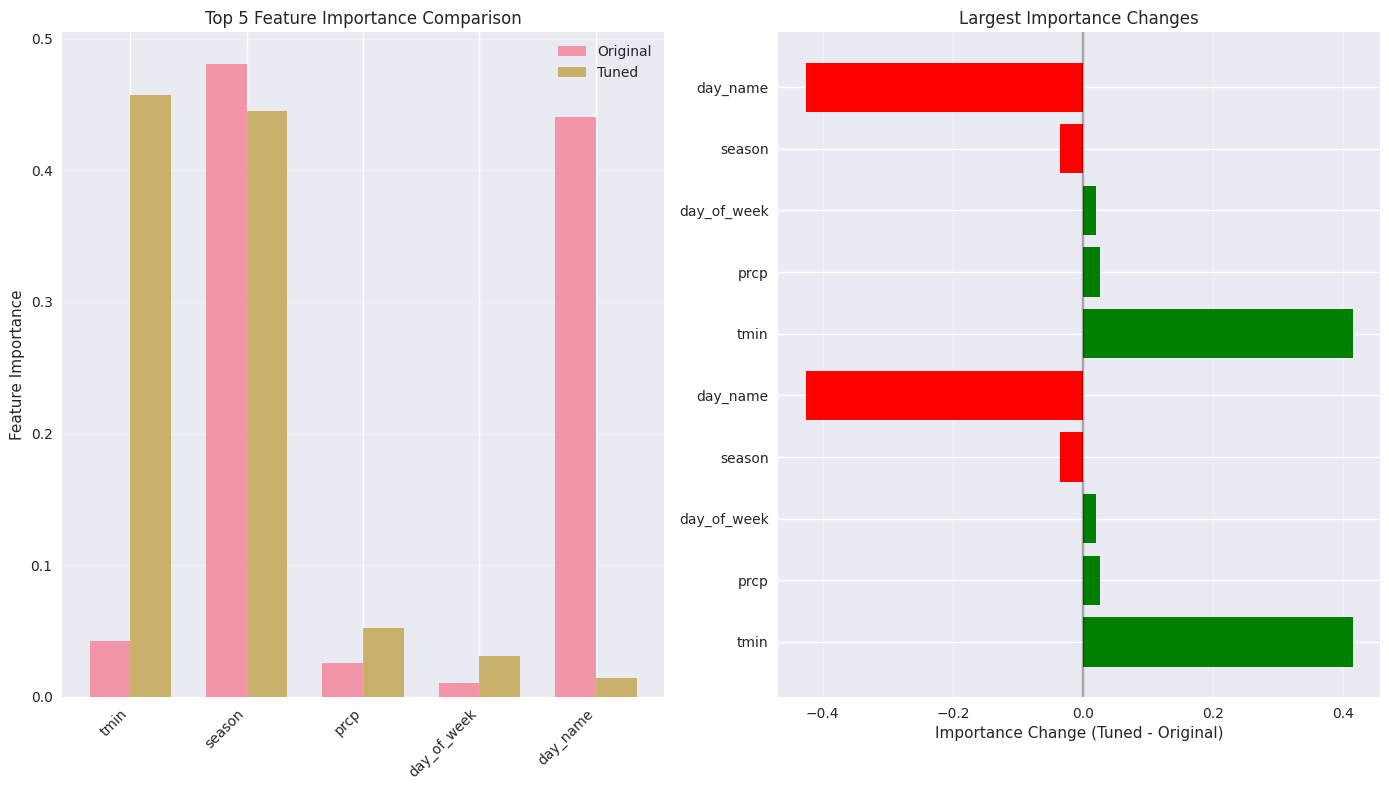


Top 5 Most Important Features (Tuned Model):
    feature  tuned_importance
       tmin          0.456852
     season          0.445026
       prcp          0.052418
day_of_week          0.031065
   day_name          0.014639

Largest Importance Increases:
    feature  importance_change
       tmin           0.414417
       prcp           0.026779
day_of_week           0.020550

Largest Importance Decreases:
 feature  importance_change
day_name          -0.426098
  season          -0.035647


In [22]:
# %%
# Feature Importance Comparison
def compare_feature_importance(original_model, tuned_model, feature_names):
    """Compare feature importance between original and tuned models"""
    
    if original_model:
        orig_importance = original_model.feature_importances_
        tuned_importance = tuned_model.feature_importances_
        
        # Create comparison dataframe
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'original_importance': orig_importance,
            'tuned_importance': tuned_importance,
            'importance_change': tuned_importance - orig_importance
        }).sort_values('tuned_importance', ascending=False)
        
        # Plot comparison
        fig, axes = plt.subplots(1, 2, figsize=(14, 8))
        
        # Top 10 features comparison
        top_n = min(10, len(feature_names))
        top_features = importance_df.head(top_n)
        
        x = np.arange(top_n)
        width = 0.35
        
        axes[0].bar(x - width/2, top_features['original_importance'], width, label='Original', alpha=0.7)
        axes[0].bar(x + width/2, top_features['tuned_importance'], width, label='Tuned', alpha=0.7)
        axes[0].set_xticks(x)
        axes[0].set_xticklabels(top_features['feature'], rotation=45, ha='right')
        axes[0].set_ylabel('Feature Importance')
        axes[0].set_title(f'Top {top_n} Feature Importance Comparison')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3, axis='y')
        
        # Importance changes
        importance_df_sorted = importance_df.sort_values('importance_change', ascending=False)
        top_changes = pd.concat([importance_df_sorted.head(5), importance_df_sorted.tail(5)])
        
        colors = ['green' if x > 0 else 'red' for x in top_changes['importance_change']]
        axes[1].barh(range(len(top_changes)), top_changes['importance_change'], color=colors)
        axes[1].set_yticks(range(len(top_changes)))
        axes[1].set_yticklabels(top_changes['feature'])
        axes[1].set_xlabel('Importance Change (Tuned - Original)')
        axes[1].set_title('Largest Importance Changes')
        axes[1].axvline(x=0, color='black', linestyle='-', alpha=0.3)
        axes[1].grid(True, alpha=0.3, axis='x')
        
        plt.tight_layout()
        plt.show()
        
        print(f"\nTop 5 Most Important Features (Tuned Model):")
        print(importance_df[['feature', 'tuned_importance']].head(5).to_string(index=False))
        
        print(f"\nLargest Importance Increases:")
        increases = importance_df[importance_df['importance_change'] > 0].nlargest(3, 'importance_change')
        print(increases[['feature', 'importance_change']].to_string(index=False))
        
        print(f"\nLargest Importance Decreases:")
        decreases = importance_df[importance_df['importance_change'] < 0].nsmallest(3, 'importance_change')
        print(decreases[['feature', 'importance_change']].to_string(index=False))

# Compare feature importance
compare_feature_importance(original_model, best_model, feature_cols)

In [23]:
# %%
# Save tuned model and results
def save_tuned_model_and_results(model, scaler, random_search, test_metrics, output_dir):
    """Save tuned model and all results"""
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Save model
    joblib.dump(model, output_dir / "gradient_boosting_tuned.pkl")
    joblib.dump(scaler, output_dir / "feature_scaler.pkl")
    
    # Save best parameters
    best_params = random_search.best_params_
    with open(output_dir / "best_parameters.json", 'w') as f:
        json.dump(best_params, f, indent=2)
    
    # Save CV results
    cv_results_df = pd.DataFrame(random_search.cv_results_)
    cv_results_df.to_csv(output_dir / "cv_results.csv", index=False)
    
    # Save test metrics
    metrics_dict = {
        'test_accuracy': float(test_accuracy),
        'test_recall': float(test_recall),
        'test_precision': float(test_precision),
        'test_f1': float(test_f1),
        'test_roc_auc': float(test_roc_auc),
        'best_cv_score': float(random_search.best_score_)
    }
    
    with open(output_dir / "tuned_model_metrics.json", 'w') as f:
        json.dump(metrics_dict, f, indent=2)
    
    # Save ANOVA results
    if anova_results is not None:
        anova_results.to_csv(output_dir / "anova_results.csv", index=False)
    
    print(f"\n✅ Tuned model and results saved to: {output_dir}")

# Save everything
MODELS_DIR = Path("../../models")
save_tuned_model_and_results(
    best_model,
    scaler,
    random_search,
    {
        'accuracy': test_accuracy,
        'recall': test_recall,
        'precision': test_precision,
        'f1': test_f1,
        'roc_auc': test_roc_auc
    },
    MODELS_DIR / "gradient_boosting_tuned"
)


✅ Tuned model and results saved to: ../../models/gradient_boosting_tuned


In [24]:
# %%
# Final Summary
print("\n" + "="*70)
print("HYPERPARAMETER TUNING - FINAL SUMMARY")
print("="*70)
print(f"🎯 Best CV F1 Score: {random_search.best_score_:.4f}")
print(f"📊 Test F1 Score:    {test_f1:.4f}")
print(f"🎯 Test Recall:      {test_recall:.4f}")
print(f"📈 Test ROC-AUC:     {test_roc_auc:.4f}")

print(f"\n🎯 Best Parameters Found:")
for param, value in random_search.best_params_.items():
    print(f"  {param}: {value}")

if original_model:
    f1_improvement = test_f1 - orig_f1
    recall_improvement = test_recall - orig_recall
    
    print(f"\n📈 Improvements over Original Model:")
    print(f"  F1-Score:  {f1_improvement:+.4f}")
    print(f"  Recall:    {recall_improvement:+.4f}")
    
    if f1_improvement > 0:
        print(f"  ✅ Hyperparameter tuning improved performance!")
    else:
        print(f"  ⚠️  Original model performed better on test set")


HYPERPARAMETER TUNING - FINAL SUMMARY
🎯 Best CV F1 Score: 0.3306
📊 Test F1 Score:    0.3312
🎯 Test Recall:      0.2311
📈 Test ROC-AUC:     0.9074

🎯 Best Parameters Found:
  subsample: 1.0
  n_estimators: 50
  min_samples_split: 100
  min_samples_leaf: 10
  max_features: None
  max_depth: 7
  learning_rate: 0.2

📈 Improvements over Original Model:
  F1-Score:  +0.1918
  Recall:    +0.1118
  ✅ Hyperparameter tuning improved performance!


In [25]:
# Statistical significance of improvement
if original_model and len(cv_results_df) > 0:
    print(f"\n📊 Statistical Analysis:")
    print(f"  Models tested: {len(cv_results_df)}")
    print(f"  Best CV score: {random_search.best_score_:.4f}")
    print(f"  Mean CV score: {cv_results_df['mean_test_score'].mean():.4f}")
    print(f"  CV score std:  {cv_results_df['mean_test_score'].std():.4f}")

print("\n🎯 Recommendation:")
if test_recall > 0.6:
    print("  ✅ Model achieves good outage detection (recall > 0.6)")
elif test_recall > 0.4:
    print("  ⚠️  Model has moderate outage detection (recall 0.4-0.6)")
else:
    print("  ❌ Model has poor outage detection (recall < 0.4)")


📊 Statistical Analysis:
  Models tested: 5
  Best CV score: 0.3306
  Mean CV score: 0.2391
  CV score std:  0.1437

🎯 Recommendation:
  ❌ Model has poor outage detection (recall < 0.4)
